# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

**Заказчик исследования** — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. 

Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

На разработку системы прогнозирования заложен бюджет — 400 000. 

**Цели проекта:**
1. Обеспечить окупаемость модели менее, чем за год.
2. Посредством анализа имеющихся данных предоставить портрет "ненадежного" клиента.

###  Откроем файлы с данными

In [2]:
# импорт необходимых библиотек и инструментов

import pandas as pd
import numpy as np
import math 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib as plt
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score

import warnings 
warnings.filterwarnings('ignore')

STATE = 43

In [3]:
train = pd.read_csv('C:/Users/user/Desktop/сборные/сборный - 2/hotel_train.csv')
display(train.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [4]:
test = pd.read_csv('C:/Users/user/Desktop/сборные/сборный - 2/hotel_test.csv')
display(test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


Объединим датасеты для использования на шаге "Портрет ненадежного клиента".

In [5]:
data_train = train.copy()
data_test = test.copy()

In [6]:
data_all = data_train.append(data_test)

### Предобработка и исследовательский анализ данных

In [7]:
def info(data):
    print('Общая информация о данных')
    data.info()
    print()
    print('Количество пропусков в каждом столбце')
    print(data.isnull().sum())
    print()
    print('Количество дубликатов')
    print(data.duplicated().sum())
    print()
    print('Количество уникальных значений (для последующих расчетов):')
    print('Месяцы - ', data.arrival_date_month.unique())
    print()
    print('Годы - ', data.arrival_date_year.unique())
    print()
    display(data.describe())
    print()
    print('Посмотрим наличие выбросов, наличие которых предполагается по статистическим данным')   
    #data = plt.figure(figsize=(20,15))
    data.boxplot(column=['babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 
                         'days_in_waiting_list'], figsize=(13,5))
    return 

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal  

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000



Посмотрим наличие выбросов, наличие которых предполагается по статистическим данным


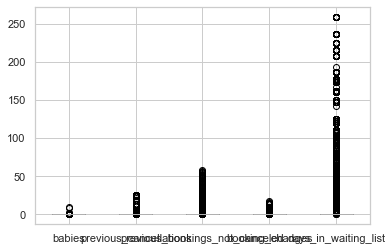

In [8]:
info(data_train)

In [9]:
# посмотрим на размеры имеющегося тренировочного датасета
data_train.shape

(65229, 25)

In [10]:
''' так как значения в столбце 'id' не несут важной для исследования информации, 
# принимаем решение удалить их. Пока соберем в переменную col_drop, чтобы удалить столбцы 
# не нужные в исследовании разом.'''
col_drop = ['id']

In [11]:
# посмотрим количество уникальных значений в столбце 'lead_time'
len(data_train['lead_time'].unique())

369

In [12]:
# посмотрим количество каждого значения в столбце 'lead_time'
data_train['lead_time'].value_counts()

0.0      3423
1.0      1984
2.0      1156
3.0      1051
4.0       994
5.0       944
6.0       820
7.0       706
12.0      664
8.0       663
11.0      612
9.0       574
14.0      574
16.0      573
10.0      524
19.0      514
17.0      494
18.0      494
34.0      493
13.0      470
37.0      455
39.0      454
36.0      443
15.0      427
40.0      423
32.0      423
35.0      412
30.0      404
44.0      399
68.0      398
20.0      392
28.0      390
33.0      388
22.0      387
41.0      381
29.0      376
56.0      375
55.0      374
72.0      371
24.0      363
50.0      363
27.0      362
21.0      361
69.0      357
31.0      345
25.0      342
47.0      341
45.0      338
53.0      330
23.0      327
74.0      326
26.0      324
86.0      303
71.0      298
57.0      290
59.0      287
98.0      285
102.0     285
46.0      280
49.0      280
48.0      277
38.0      277
61.0      276
92.0      273
64.0      273
54.0      272
87.0      270
99.0      268
65.0      264
42.0      263
43.0      259
115.0 

Оставляем столбец 'lead_time' для дальнейшего исследования.

In [13]:
data_train['arrival_date_year'].unique()

array([2015, 2016], dtype=int64)

In [14]:
data_test['arrival_date_year'].unique()

array([2017], dtype=int64)

В датафреймах мы имеем данные за 2015, 2016 (data_train) и 2017 (data_test) годы. Сами даты не несут важной для исследования информации. соберем в переменную col_drop, чтобы удалить столбцы не нужные в исследовании разом

In [15]:
col_drop.append('arrival_date_year')

In [16]:
# посмотрим на уникальные значения столбца 'arrival_date_month' на тренировочной выборке
data_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [17]:
# посмотрим на уникальные значения столбца 'arrival_date_month' на тестовой выборке
data_test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

В тренировочной выборке у нас имеются данные за период с июля 2015 года по декабрь 2016 года. А в тестовой - с января по август включительно 2017 года. Данный столбец оставляем.

In [18]:
display(data_train['country'].value_counts())

PRT    28831
FRA     5974
GBR     5109
ESP     4900
DEU     3887
ITA     2327
IRL     1445
BEL     1245
NLD     1166
BRA     1088
USA     1008
CHE      874
AUT      716
SWE      544
POL      531
CHN      526
CN       488
ISR      375
RUS      296
NOR      261
ROU      249
FIN      241
DNK      201
TUR      169
AUS      168
AGO      140
LUX      134
MAR      125
HUN      121
JPN      117
CZE      112
ARG      107
IND       88
GRC       81
SRB       81
KOR       68
DZA       62
HRV       54
IRN       52
THA       48
BGR       48
UKR       46
EST       45
SVN       45
SVK       44
MEX       44
NZL       44
LTU       43
CHL       42
ZAF       36
COL       36
MOZ       34
LVA       30
TUN       29
ARE       26
SGP       26
TWN       25
EGY       24
MYS       21
ISL       21
VEN       20
IDN       19
SAU       19
NGA       18
LBN       18
CYP       18
HKG       16
CPV       15
PER       15
IRQ       12
CRI       12
JOR       12
MLT       12
BLR       11
GEO       10
URY       10
KWT       10

Так как в столбце 'country' большая разница между количеством посетителей из разных стран, сохранение этого столбца может быть неинформативно. К примеру, из QAT из 6 общих заказов - 2 отказа и из IRL из 1445 - 2 отказа. К тому же если использовать кодирование по нумерации значений (который в данном случае подходит), он может привести к плохому результату так как, алгоритмы начинают учитывать бессмысленную упорядоченность значений признаков. Принимаем решение этот столбец также удалить.

In [19]:
col_drop.append('country')

Столбцы 'arrival_date_week_number' и 'arrival_date_day_of_month' неинформативны, так как номер недели дублирует месяц, а дата заезда не дает информации о поведении клиентов. Их также будем удалять.

In [20]:
col_drop.append('arrival_date_week_number')

In [21]:
col_drop.append('arrival_date_day_of_month')

In [22]:
data_train.corr()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
id,1.000000,-0.241910,0.004571,0.249393,0.070340,0.009171,-0.094065,-0.157561,0.001824,0.007738,-0.023737,0.002787,-0.003855,0.016588,-0.001738,-0.023523,-0.114431,0.124479,-0.169021
is_canceled,-0.241910,1.000000,0.328142,-0.030835,0.012869,-0.001903,-0.013767,0.010650,0.045153,-0.017746,-0.029589,-0.040242,0.153023,-0.045557,-0.142935,0.075848,-0.186486,-0.257061,0.001542
lead_time,0.004571,0.328142,1.000000,-0.022997,0.091603,-0.010252,0.047003,0.172646,0.119617,-0.056359,-0.024649,-0.089424,0.142454,-0.061690,-0.007191,0.209741,-0.116867,-0.147738,0.157671
arrival_date_year,0.249393,-0.030835,-0.022997,1.000000,-0.388003,0.009789,-0.006474,0.013744,0.029102,0.052613,-0.007381,-0.005957,-0.134027,0.040137,0.041387,0.027224,0.014875,0.089731,0.007535
arrival_date_week_number,0.070340,0.012869,0.091603,-0.388003,1.000000,0.048372,0.034029,0.032295,0.005638,-0.007255,0.003938,-0.013471,0.006870,-0.011915,0.011799,-0.052976,-0.007533,0.076650,0.041886
arrival_date_day_of_month,0.009171,-0.001903,-0.010252,0.009789,0.048372,1.000000,-0.002017,0.003705,0.006034,0.018558,-0.000482,-0.010605,-0.032019,-0.000973,0.022560,0.017070,0.003816,0.005875,0.001898
stays_in_weekend_nights,-0.094065,-0.013767,0.047003,-0.006474,0.034029,-0.002017,1.000000,0.197410,0.116679,0.026224,0.018822,-0.081943,-0.008727,-0.025560,0.023118,-0.065167,-0.015870,0.083682,0.644935
stays_in_week_nights,-0.157561,0.010650,0.172646,0.013744,0.032295,0.003705,0.197410,1.000000,0.119901,0.023590,0.018428,-0.094617,-0.006098,-0.049188,0.061721,0.036037,-0.026988,0.090359,0.876515
adults,0.001824,0.045153,0.119617,0.029102,0.005638,0.006034,0.116679,0.119901,1.000000,-0.003216,0.019756,-0.157053,0.003083,-0.115353,-0.056396,-0.013475,0.013321,0.171793,0.150766
children,0.007738,-0.017746,-0.056359,0.052613,-0.007255,0.018558,0.026224,0.023590,-0.003216,1.000000,0.018410,-0.026707,-0.027357,-0.015807,0.053835,-0.038615,0.047881,0.112699,0.031268


Общее количество ночей 'total_nights' коррелирует с количеством ночей в выходные дни 'stays_in_weekend_nights' и количеством ночей в будние дни 'stays_in_week_nights'. Можем его удалить.

In [23]:
col_drop.append('total_nights')

Данные столбцов 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests' оставляем для дальнейшего исследования. 

Посмотрим в data_train строки со значением столбца 'babies' больше 5:

In [24]:
display(data_train[data_train['babies']>5])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,January,3,12,0,2,2.0,0.0,10.0,BB,PRT,TA/TO,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11.0,2015,October,42,11,2,1,1.0,0.0,9.0,BB,GBR,Corporate,0,0,0,A,1,0,Transient-Party,0,0,3


Маловероятно, что 2 и 1 взрослый человек остановились в отеле с 10 и 9 младенцами соответственно. Удалим эти 2 строки:

In [25]:
data_train = data_train[data_train['babies'] < 5]

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal  

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000



Посмотрим наличие выбросов, наличие которых предполагается по статистическим данным


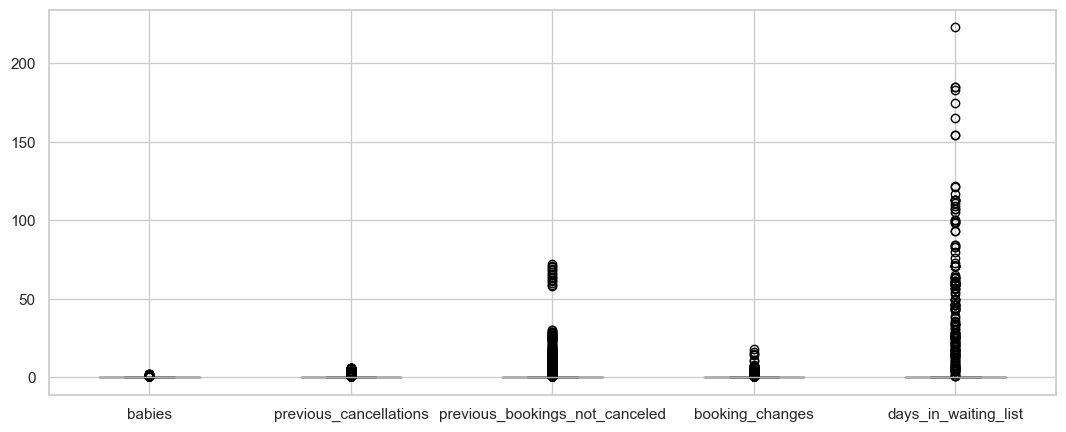

In [26]:
info(data_test)

В данных датасетов data_train и data_test пропущенные значения и явные дубликаты отсутствуют. 

Удаляем лишние пробелы в датафрейме: 

In [27]:
# удалем лишние пробелы в датафрейме 
train['reserved_room_type'] = train['reserved_room_type'].str.strip()
train['meal'] = train['meal'].str.strip()
test['reserved_room_type'] = test['reserved_room_type'].str.strip()
test['meal'] = test['meal'].str.strip()

### Формулировка ML-задачи на основе бизнес-задачи

Добавим в тестовый датасет данные о стоимости номеров за одну ночь и стоимость уборки.

In [28]:
def def_price_night(row):
    room_type = row['reserved_room_type']
    if room_type == 'A':
        return 1000
    if room_type == 'B':
        return 800
    if room_type == 'C':
        return 600
    if room_type == 'D':
        return 550
    if room_type == 'E':
        return 500
    if room_type == 'F':
        return 450
    if room_type == 'G':
        return 350
    
test['price_night'] = test.apply(def_price_night, axis=1)
display(test.head())

#train['price_night'] = train.apply(def_price_night, axis=1)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_night
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000


In [29]:
def def_cost_service(row):
    room_type = row['reserved_room_type']
    if room_type == 'A':
        return 400
    if room_type == 'B':
        return 350
    if room_type == 'C':
        return 350
    if room_type == 'D':
        return 150
    if room_type == 'E':
        return 150
    if room_type == 'F':
        return 150
    if room_type == 'G':
        return 150
     
test['cost_service'] = test.apply(def_cost_service, axis=1)
display(test.head())

#data_train['cost_service'] = data_train.apply(def_cost_service, axis=1)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_night,cost_service
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,400
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,400


Добавим данные в датасет о стоимости номеров с учетом сезонности.

In [30]:
def def_koef_season(row):
    season = row['arrival_date_month']
    if season in ('March', 'April', 'May', 'September', 'October', 'November'):
        return row['price_night'] * 1.2
    if season in ('June', 'July', 'August'):
        return row['price_night'] * 1.4
    else:
        return row['price_night']

test['price_with_koef_season'] = test.apply(def_koef_season, axis=1)  
test.sample(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_night,cost_service,price_with_koef_season
26833,92325,0,225.0,2017,May,21,25,0,3,2.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,1,3,1000,400,1200.0
25432,90924,0,109.0,2017,May,18,5,1,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,D,0,0,Transient,0,0,3,550,150,660.0
6732,23686,0,128.0,2017,June,25,19,1,5,2.0,0.0,0.0,BB,BRA,TA/TO,0,0,0,F,1,0,Transient,1,2,6,450,150,630.0
31263,96755,0,171.0,2017,August,32,9,0,4,2.0,0.0,0.0,BB,NLD,TA/TO,0,0,0,A,1,0,Transient,0,0,4,1000,400,1400.0
23383,88875,0,91.0,2017,April,14,2,2,2,2.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,1,0,Transient,0,4,4,1000,400,1200.0


Создаем функцию подсчета прибыли отеля не учитывая депозит.

In [31]:
def def_profit_hotel(row):
    if row['is_canceled'] == 0:
        
        if row['total_nights'] % 2 != 0:
            number_of_cleanings = (math.floor(row['total_nights'] / 2) + 1)
        else:
            number_of_cleanings = (math.floor(row['total_nights'] / 2))
                                   
        revenue = row['total_nights'] * row['price_with_koef_season']
        losses = row['cost_service'] * number_of_cleanings
        return revenue - losses
                                   
    return (row['cost_service'] + row['price_with_koef_season']) * -1

Добавляем столбец 'profit' - прибыль отеля без учета депозита в тренировочный датасет.

In [32]:
test['profit'] = test.apply(def_profit_hotel, axis=1)

In [33]:
test.sample(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_night,cost_service,price_with_koef_season,profit
28751,94243,0,30.0,2017,June,26,26,1,2,3.0,0.0,0.0,BB,SGP,TA/TO,0,0,0,D,0,0,Transient,0,0,3,550,150,770.0,2010.0
27982,93474,0,155.0,2017,June,24,12,1,3,3.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,0,4,550,150,770.0,2780.0
10549,47738,1,2.0,2017,March,13,30,0,1,1.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,1,0,Transient,0,0,1,1000,400,1200.0,-1600.0
26660,92152,0,208.0,2017,May,21,24,0,2,1.0,0.0,0.0,HB,DEU,TA/TO,0,0,0,A,1,0,Transient-Party,0,0,2,1000,400,1200.0,2000.0
29706,95198,0,0.0,2017,July,28,14,0,1,2.0,0.0,0.0,SC,DEU,TA/TO,0,0,0,A,0,0,Transient,0,2,1,1000,400,1400.0,1000.0


In [34]:
display('Прибыль отеля без учета депозита за период с января по август 2017 года:', test['profit'].sum()) 

'Прибыль отеля без учета депозита за период с января по август 2017 года:'

35300770.0

### Разработка модели ML

#### Проверка наличия дисбаланса

Проверим наличие дисбаланса классов в столбце клиентов, отменивших заказ "is_canceled":

0    41183
1    24044
Name: is_canceled, dtype: int64

<AxesSubplot:xlabel='is_canceled', ylabel='count'>

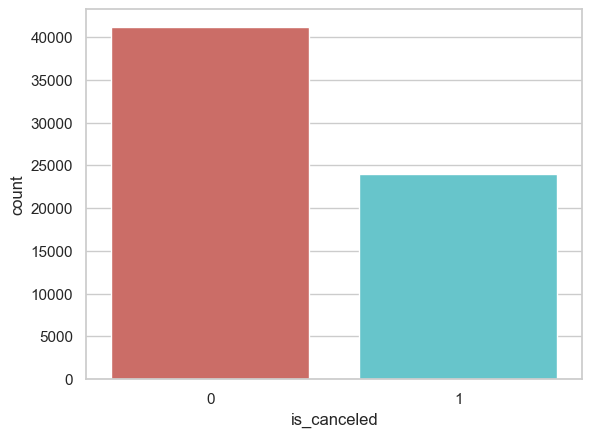

In [35]:
display(data_train['is_canceled'].value_counts())
sns.countplot(x='is_canceled', data=data_train, palette='hls')


Получаем разницу в 2 раза в имеющихся данных. 

#### Подготовим данные для машинного обучения

In [36]:
data_train = data_train.drop(col_drop, axis=1)
data_test = data_test.drop(col_drop, axis=1)

In [37]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65227 entries, 0 to 65228
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     65227 non-null  int64  
 1   lead_time                       65227 non-null  float64
 2   arrival_date_month              65227 non-null  object 
 3   stays_in_weekend_nights         65227 non-null  int64  
 4   stays_in_week_nights            65227 non-null  int64  
 5   adults                          65227 non-null  float64
 6   children                        65227 non-null  float64
 7   babies                          65227 non-null  float64
 8   meal                            65227 non-null  object 
 9   distribution_channel            65227 non-null  object 
 10  is_repeated_guest               65227 non-null  int64  
 11  previous_cancellations          65227 non-null  int64  
 12  previous_bookings_not_canceled  

In [38]:
# проверим на наличие дубликатов, удалим дубликаты и перепроверим вновь 
display(f'Количество дубликатов в data_train - {data_train.duplicated().sum()}')
data_train = data_train.drop_duplicates().reset_index(drop=True)
display(f'Количество дубликатов в data_train - {data_train.duplicated().sum()}')

'Количество дубликатов в data_train - 24490'

'Количество дубликатов в data_train - 0'

In [39]:
# соберем в список категориальные данные
cat_col = [
        i for i in data_train.dtypes.index if data_train.dtypes[i] == 'object'
    ]

In [40]:
# соберем в список численные данные
num_col = [
        i for i in data_train.dtypes.index if data_train.dtypes[i] != 'object'
    ]

In [41]:
cat_col

['arrival_date_month',
 'meal',
 'distribution_channel',
 'reserved_room_type',
 'customer_type']

In [42]:
num_col

['is_canceled',
 'lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [43]:
# удаляем целевой признак 
num_col.remove('is_canceled')

In [44]:
num_col

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests']

Проведем кодирование оставшихся столбцов с категориальными данными.

In [45]:
enc = OneHotEncoder(handle_unknown='ignore')

cat_features_train = data_train[cat_col]
cat_features_test = data_test[cat_col]

enc.fit(cat_features_train)
cat_features_train = pd.DataFrame(
    enc.transform(cat_features_train).toarray(), 
    columns=enc.get_feature_names(cat_col)
)

cat_features_train.head(3)

,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,meal_SC,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
cat_features_test = pd.DataFrame(
    enc.transform(cat_features_test).toarray(), 
    columns=enc.get_feature_names(cat_col)
)

cat_features_test.head(3)

,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,meal_SC,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [47]:
# Инициализация стандартизатора
scaler = StandardScaler()

# Передача датасета и преобразование
scaler.fit(data_train[num_col])
data_train[num_col] = scaler.transform(data_train[num_col])

data_test[num_col] = scaler.transform(data_test[num_col])


data_train.head()

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,0,-0.846363,July,-1.05959,-0.931763,-1.736067,-0.280512,-0.104863,BB,Direct,-0.18921,-0.093992,-0.100643,A,-0.369814,-0.078175,Transient,-0.306209,-0.854873
1,0,-0.751595,July,-1.05959,-0.248747,0.256050,-0.280512,-0.104863,BB,TA/TO,-0.18921,-0.093992,-0.100643,A,-0.369814,-0.078175,Transient,-0.306209,0.378699
2,0,-0.941132,July,-1.05959,-0.248747,0.256050,-0.280512,-0.104863,BB,Direct,-0.18921,-0.093992,-0.100643,C,-0.369814,-0.078175,Transient,-0.306209,-0.854873
3,0,-0.819287,July,-1.05959,-0.248747,0.256050,-0.280512,-0.104863,FB,Direct,-0.18921,-0.093992,-0.100643,C,-0.369814,-0.078175,Transient,-0.306209,0.378699
4,1,0.209624,July,-1.05959,0.434268,0.256050,-0.280512,-0.104863,BB,TA/TO,-0.18921,-0.093992,-0.100643,A,-0.369814,-0.078175,Transient,-0.306209,0.378699


In [48]:
# удаляем категориальные данные из датафреймов для последующего объединения с кодированными признаками
data_train = data_train.drop(cat_col, axis=1)
data_test = data_test.drop(cat_col, axis=1)

In [49]:
# объединяем с кодированными категориальными признаками
data_train = pd.concat((data_train, cat_features_train), axis=1)

In [50]:
# проверим наличие отсутствующих значений
data_train.isna().sum()

is_canceled                            0
lead_time                              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               0
babies                                 0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
booking_changes                        0
days_in_waiting_list                   0
required_car_parking_spaces            0
total_of_special_requests              0
arrival_date_month_April               0
arrival_date_month_August              0
arrival_date_month_December            0
arrival_date_month_February            0
arrival_date_month_January             0
arrival_date_month_July                0
arrival_date_month_June                0
arrival_date_month_March               0
arrival_date_month_May                 0
arrival_date_month_November            0
arrival_date_mon

In [51]:
data_test = pd.concat((data_test, cat_features_test), axis=1)

In [52]:
# проверим наличие отсутствующих значений
data_test.isna().sum()

is_canceled                            0
lead_time                              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               0
babies                                 0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
booking_changes                        0
days_in_waiting_list                   0
required_car_parking_spaces            0
total_of_special_requests              0
arrival_date_month_April               0
arrival_date_month_August              0
arrival_date_month_December            0
arrival_date_month_February            0
arrival_date_month_January             0
arrival_date_month_July                0
arrival_date_month_June                0
arrival_date_month_March               0
arrival_date_month_May                 0
arrival_date_month_November            0
arrival_date_mon

#### Модели машинного обучения

In [53]:
# разделим целевой признак и остальные признаки
features_train = data_train.drop(['is_canceled'], axis=1)
target_train = data_train['is_canceled']

In [54]:
features_test = data_test.drop(['is_canceled'], axis=1)
target_test = data_test['is_canceled']

Подготовим функцию. Метрикой выберем F1-меру.

##### Логистическая регрессия

In [55]:
model_lr = LogisticRegression(class_weight='balanced', random_state=STATE)
param={
    'penalty': ('l1', 'l2', 'none'),
    'C': range(1, 6), 
    'solver': ('lbfgs', 'liblinear', 'sag')
}
gs = GridSearchCV(model_lr, param_grid=param, scoring='f1', n_jobs=-1, cv=3)
gs.fit(features_train, target_train)

print('Гиперпараметры лучшей модели:', gs.best_params_) 
print('Значение f1:', gs.best_score_)

Гиперпараметры лучшей модели: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Значение f1: 0.3890945525781131


##### Случайный лес

In [56]:
# подберем гиперпараметры
model_rf = RandomForestClassifier(class_weight='balanced', random_state=STATE)
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
gs = GridSearchCV(model_rf, param_grid=parametrs, scoring='f1', n_jobs=-1, cv=3)
gs.fit(features_train, target_train)

print('Гиперпараметры лучшей модели:', gs.best_params_) 
print('Значение f1:', gs.best_score_)

Гиперпараметры лучшей модели: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Значение f1: 0.49816981325299503


Лучшуй моделью оказалась "Случайный лес". Используем для тестового датасета лучшую модель.

#### Лучшая модель - "Случайный лес"

In [57]:
model = RandomForestClassifier(
    random_state=STATE,  
    max_depth=1, 
    n_estimators=30, 
    min_samples_leaf=1, 
    min_samples_split=2, 
    class_weight='balanced'
)
model.fit(features_train, target_train)
predicted = model.predict(features_test)

display('F1-мера модели:', f1_score(target_test, predicted))
display('ROC-AUC модели:', roc_auc_score(target_test, predicted))

'F1-мера модели:'

0.6351778656126482

'ROC-AUC модели:'

0.6545935419118095

#### Вычисляем прибыль с учетом использования модели ML

Вычислим прибыль, полученную отелем за известный нам период с января по август 2017 года (data_test) при использовании модели. То есть учтем депозит для пользователей, которые по прогнозу модели откажутся от брони номера.

Бюджет на разработку модели ML составил 400 000 руб. Он должен окупиться за год.

In [58]:
BUDGET = 400000
# коэффициент депозита
deposit_koef = 0.8

Добавим в data_test столбцы с предсказаниями лучшей модели.

In [59]:
test['predict_LR'] = pd.Series(predicted).reset_index(drop=True)

In [60]:
display(test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_night,cost_service,price_with_koef_season,profit,predict_LR
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,400,1000.0,-1400.0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1000.0,-1400.0,1
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1000.0,-1400.0,1
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1000.0,-1400.0,1
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,400,1000.0,-1400.0,1


In [61]:
# создадим функцию подсчета прибыли отеля с учетом депозита

def def_profit_hotel_deposit_LR(row):
    if row['is_canceled'] == 0:
        if row['total_nights'] % 2 != 0:
            number_of_cleanings = (math.floor(row['total_nights'] / 2) + 1)
        else:
            number_of_cleanings = (math.floor(row['total_nights'] / 2))
        revenue = row['total_nights'] * row['price_with_koef_season']
        losses = row['cost_service'] * number_of_cleanings
        return revenue - losses
                                   
    if row['is_canceled'] == 1 and row['predict_LR'] == 0:                          
        return (row['cost_service'] + row['price_with_koef_season']) * -1
    
    if row['is_canceled'] == 1 and row['predict_LR'] == 1:                          
        return (
             (row['cost_service'] + row['price_with_koef_season']) * -1 + 
             (row['cost_service'] + row['price_with_koef_season']) * 0.8
         )

In [62]:
profit_hotel_2017_deposit = test.apply(def_profit_hotel_deposit_LR, axis=1)

In [63]:
display(f'Прибыль отеля за период с января по август 2017 года составила: {sum(profit_hotel_2017_deposit)} руб.') 

'Прибыль отеля за период с января по август 2017 года составила: 48251186.0 руб.'

In [64]:
profit_hotel_without_model = test['profit'].sum()
profit_hotel_without_model

35300770.0

In [65]:
display(f'Прибыль отеля за период с января по август 2017 года увеличилась с использованием модели на {sum(profit_hotel_2017_deposit) - profit_hotel_without_model} руб') 

'Прибыль отеля за период с января по август 2017 года увеличилась с использованием модели на 12950416.0 руб'

Посчитаем среднемесячную прибыль из данных за 8 месяцев 2017 года и приблизительную прибыль за 2017 год:

In [66]:
display(f'Среднемесячная прибыль составила: {sum(profit_hotel_2017_deposit)/8} руб.')

'Среднемесячная прибыль составила: 6031398.25 руб.'

Вычтем из среднемесячной прибыли бюджет на разработку модели:

In [67]:
display(sum(profit_hotel_2017_deposit)/8 - BUDGET)

5631398.25

In [68]:
display(f'Годовая прибыль за 2017 год составит: {sum(profit_hotel_2017_deposit)/8*12} руб.')

'Годовая прибыль за 2017 год составит: 72376779.0 руб.'

Сопоставим годовую прибыль 2015-2016 годов с предполагаемой прибылью 2017 года (с использованием модели прогнозирования отказа от бронирования комнат):

In [69]:
display(f'Деятельность отеля с внедрением модели прогнозирования стала эффективнее на {(sum(profit_hotel_2017_deposit)*100 / profit_hotel_without_model) - 100} %')

'Деятельность отеля с внедрением модели прогнозирования стала эффективнее на 36.685930646838585 %'

**В итоге мы получили следующие результаты: 1. Модель окупилась в первый же месяц. 2. Прибыль отеля за период с января по август 2017 года увеличилась с использованием модели на 12 950 416 руб, что больше на 36,7 %.** 

### Портрет «ненадёжного» клиента

Для выявления зависимости ненадежности клиентов от признаков будем использовать все имеющиеся у нас данные. 

В начале посмотрим какими характеристиками обладают клиенты, имеющие максимальное количество отказов от брони (столбец "previous_cancellations"). Для этого использовали данные команды describe().

In [70]:
display(data_all[data_all['previous_cancellations']>5])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
6273,8602,1,275.0,2015,October,41,4,2,0,2.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6274,8603,1,275.0,2015,October,41,4,2,0,2.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6275,8604,1,275.0,2015,October,41,4,2,0,2.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6276,8605,1,275.0,2015,October,41,4,2,0,2.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6277,8606,1,275.0,2015,October,41,4,2,0,2.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6278,8607,1,275.0,2015,October,41,4,2,0,2.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6279,8608,1,275.0,2015,October,41,4,2,0,2.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6280,8609,1,275.0,2015,October,41,4,2,0,2.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6281,8610,1,275.0,2015,October,41,4,2,0,2.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6282,8611,1,275.0,2015,October,41,4,2,0,2.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2


In [71]:
def portret_klient(row, sign):
    df_pivot_table = pd.pivot_table(data_all, index=sign, values='is_canceled', aggfunc = ['sum', 'count'])
    df_pivot_table['% отказа от брони номера'] = df_pivot_table['sum'] / df_pivot_table['count'] * 100
    return display(df_pivot_table.sort_values(by='% отказа от брони номера', ascending=False))

In [72]:
portret_klient(data_all, 'arrival_date_year')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
arrival_date_year,,,
2015,7192,18328,39.240506
2017,12591,32412,38.846723
2016,16852,46901,35.931004


За период с 2015 по 2017 годы % отказа от брони номера от 35,9% до 39,2%. В 2016 году минимальное количество отказов, в 2015 году - максимальное.

In [73]:
portret_klient(data_all, 'lead_time')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
lead_time,,,
374.0,20,20,100.000000
372.0,44,44,100.000000
366.0,1,1,100.000000
358.0,66,66,100.000000
357.0,17,17,100.000000
344.0,59,61,96.721311
373.0,27,28,96.428571
350.0,87,92,94.565217


Есть тенденция, говорящая о том, что если количество дней между датой бронирования и датой прибытия больше 3 месяцев, то вероятность отказа от брони более 60%.

In [74]:
portret_klient(data_all, 'arrival_date_month')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
arrival_date_month,,,
June,3984,9239,43.121550
April,4059,9682,41.923156
May,3988,9939,40.124761
September,3487,8782,39.706217
October,3566,9255,38.530524
July,3552,9344,38.013699
August,3699,9774,37.845304
December,1913,5497,34.800800


Отказы от брони каждый месяц составляют от 30,9% до 43,1%. Самые высокие показателей отказа в июне, мае и апреле - выше 40%. 

In [75]:
portret_klient(data_all, 'stays_in_weekend_nights')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
stays_in_weekend_nights,,,
0,16702,43653,38.260830
2,9962,26578,37.482128
1,9770,26826,36.419891
3,130,362,35.911602
4,71,222,31.981982


Процент отказа от брони выше в будние ночи, нежели в выходные (этот признак мы посмотрим далее). Больше всего отказов у клиентов, бронирующих номер до 2 ночей.

In [76]:
portret_klient(data_all, 'stays_in_week_nights')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
stays_in_week_nights,,,
2,12768,29141,43.814557
3,7606,19667,38.673921
6,330,898,36.748330
4,2965,8106,36.577844
5,2748,7997,34.362886
1,8506,25888,32.856922
0,1712,5944,28.802153


Больше всего отказов у клиентов, бронирующих номер на 2 - 3 ночи.

In [77]:
portret_klient(data_all, 'adults')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
adults,,,
2.0,29051,73217,39.677944
3.0,1607,4675,34.374332
0.0,79,235,33.617021
1.0,5892,19492,30.227786
4.0,6,22,27.272727


Чаще всех отказываются от брони клиенты, прибывающие вдвоем - 39,7%.

In [78]:
portret_klient(data_all, 'children')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
children,,,
2.0,795,1989,39.969834
0.0,34706,92072,37.694413
3.0,7,21,33.333333
1.0,1127,3559,31.666198


Чаще всех отказываются от брони клиенты, имеющие двоих детей - 40%.

In [79]:
portret_klient(data_all, 'babies')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
babies,,,
0.0,36530,97014,37.654359
1.0,105,618,16.990291
2.0,0,7,0.000000
9.0,0,1,0.000000
10.0,0,1,0.000000


Чаще всех отказываются от брони клиенты, неимеющие младенцев - 37,7%.

In [80]:
portret_klient(data_all, 'meal')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
meal,,,
FB,325,487,66.735113
BB,28674,76381,37.540750
SC,3840,10309,37.249006
HB,3605,9691,37.199463
SC,191,773,24.708926


Чаще всех отказываются от брони клиенты, с опцией заказа: включён завтрак, обед и ужин - 66,7%

In [81]:
portret_klient(data_all, 'country')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
country,,,
HND,1,1,100.000000
KHM,2,2,100.000000
FJI,1,1,100.000000
GGY,3,3,100.000000
GLP,2,2,100.000000
BEN,3,3,100.000000
UMI,1,1,100.000000
IMN,2,2,100.000000


В данном случае количество клиентов из разных стран имеет весьма различные значения, поэтому считаю некорректно по одному отказу одного человека утверждать, что из конкретной страны вероятность отказа 100%. 

In [82]:
portret_klient(data_all, 'distribution_channel')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
distribution_channel,,,
TA/TO,33550,81537,41.146964
Corporate,1241,5425,22.875576
GDS,33,184,17.934783
Direct,1811,10495,17.255836


41,1% отказов от брони у клиентов канала дистрибуции заказа TA/TO.

In [83]:
portret_klient(data_all, 'is_repeated_guest')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
is_repeated_guest,,,
0,36139,94853,38.100007
1,496,2788,17.790531


38,1% отказов у клиентов, которые впервые бронируют номер, против 17,8% клиентов, которые осуществляют бронь повторно.

In [84]:
portret_klient(data_all, 'previous_cancellations')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
previous_cancellations,,,
14,11,11,100.000000
19,17,17,100.000000
21,1,1,100.000000
24,28,28,100.000000
25,19,19,100.000000
26,18,18,100.000000
1,5258,5532,95.046999
13,11,12,91.666667


В данном случае можно отметить, что имеются "постоянные" клиенты, отменяющие заказ брони. 

In [85]:
portret_klient(data_all, 'previous_bookings_not_canceled')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
previous_bookings_not_canceled,,,
25,8,15,53.333333
48,1,2,50.000000
44,1,2,50.000000
58,1,2,50.000000
0,36485,95048,38.385868
29,1,4,25.000000
26,1,6,16.666667
27,1,7,14.285714


Можно отметить, что подавляющее большинство отказов от брони (36 485 случаев из 95 048) - 38,4% - осуществлено клиентами, не подтвердившими заказ. На втором месте (59 случаев из 1069) -5,5% - клиентами, подтвердившими заказ единожды. Клиенты, подтверждающие заказ, также могут отказаться от брони, но со значительно меньшей вероятностью.

In [86]:
portret_klient(data_all, 'reserved_room_type')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
reserved_room_type,,,
A,29177,73972,39.443303
G,306,870,35.172414
B,344,1052,32.699620
D,5003,15510,32.256609
C,132,429,30.769231
F,512,1716,29.836830
E,1161,4092,28.372434


Большинство отказов от брони номера типа А - 39,4%.

In [87]:
portret_klient(data_all, 'booking_changes')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
booking_changes,,,
16,1,2,50.000000
6,15,35,42.857143
0,34510,83940,41.112700
10,1,3,33.333333
14,1,3,33.333333
8,2,8,25.000000
2,618,2914,21.207962
5,15,71,21.126761


Большинство отказов у клиентов, которые не вносили изменения в параметры заказа (34510 случаев - 41% от общего количества), или допустили внесение зменений до 2-х раз (1 раз - 1303 случаев, 2 раза - 618 случаев). 

In [88]:
portret_klient(data_all, 'days_in_waiting_list')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
days_in_waiting_list,,,
55,10,10,100.000000
24,19,19,100.000000
30,2,2,100.000000
100,2,2,100.000000
39,186,186,100.000000
41,63,63,100.000000
42,30,30,100.000000
45,65,65,100.000000


Подавляющее большинство отказов от брони у заказов, оформленных в этот же день (34 410 случаев из 94 240) - 36,5% 

In [89]:
portret_klient(data_all, 'customer_type')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
customer_type,,,
Transient,29822,72954,40.877813
Contract,1135,3105,36.553945
Transient-Party,5646,21130,26.720303
Group,32,452,7.079646


Наиболее часто - 41% - отказ от брони осуществляют заказчики не связанные с договором или групповым заездом. Наименьшая верояность отказа у группового заезда - 7%.

In [90]:
portret_klient(data_all, 'required_car_parking_spaces')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
required_car_parking_spaces,,,
0,36635,92482,39.613114
1,0,5138,0.000000
2,0,17,0.000000
3,0,2,0.000000
8,0,2,0.000000


Из имеющихся данных следует, что отказ от брони осуществляли только те клиенты, которые бронировали без места для автомобиля - 39,6%

In [91]:
portret_klient(data_all, 'total_of_special_requests')

,sum,count,% отказа от брони номера
,is_canceled,is_canceled,
total_of_special_requests,,,
0,28076,58009,48.399386
2,2299,10432,22.037960
1,5874,26995,21.759585
3,359,1943,18.476583
4,26,231,11.255411
5,1,31,3.225806


Наиболее часто - 48,4% - отмена брони у клиентов, оформлявших заказ без специальных отметок.

### Вывод

В 2017 году введена в работу ML модель, позволяющая прогнозировать отказ клиента от брони и предлагать внести депозит, состоящий из 80% суммы стоимости номера и разового обслуживания. В случае реального отказа от брони, со счета клиента списывался депозит. На разработку ML модели затрачено 400 000 руб., которые компенсировались прибылью уже в первый месяц 2017 года. Среднемесячная прибыль составила 6 031 398.25 руб.

Прибыль отеля за период с января по август 2017 года увеличилась с использованием модели на 12 950 416 руб., т.е. на 36,7%.

По прогнозу, прибыль за 2017 год, с учетом задействованной ML модели, составит 7 2376 779 руб.

**Портрет "ненадежного" клиента:** 

1. Количество дней между датой бронирования и датой прибытия больше 3 месяцев. Бронь на июнь, май и апрель.
2. Бронь номера на 1 - 3 ночи в будние дни.
3. Клиенты прибывают в количестве 2-х взрослых, с 2-мя детьми и неимеющие младенцев.
4. Клиенты не связанные с договором или групповым заездом.
5. Клиент осуществляет бронирование без места для автомобиля.
6. Бронь с опциями: включён завтрак, обед и ужин; канал дистрибуции заказа TA/TO; клиенты впервые бронируют номер; клиент не подтвердил заказ; номер типа А; клиент не вносили изменения в параметры заказа; оформлял заказ без специальных отметок.
7. Подавляющее большинство отказов от брони у заказов, оформленных в этот же день (34 410 случаев из 94 240) - 36,5%.
8. Нужно учесть, что имеются "постоянные" клиенты, отменяющие заказ брони.